<a href="https://colab.research.google.com/github/Chris-j-wu/Predicting-mRNA-subcellular-localization-using-deep-learning-models-/blob/main/DeepMRS_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount to google drive

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/DeepMRS-net

/content/drive/MyDrive/DeepMRS-net


In [3]:
%matplotlib inline
import scipy.io # loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

### Define PPM Fitting Range
- only data points from 1.5 to 4.2 PPM will be used:

In [4]:
def spec_fft(x):
    '''
    takes in FID and performs Fourier transformation
    '''
    return np.fft.fftshift(np.fft.fft(x,axis=0),axes=0)

In [5]:
PPM = np.transpose(scipy.io.loadmat('./basis_sets/OFF_7.mat')['ppm'])

In [6]:
def find_nearest(array, value):
    '''
    takes in an array and a number, finds the index of of the element in the array closest to number
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

PPM range for basis set

In [7]:
ppm_15_idx = find_nearest(PPM, value=1.5)
ppm_42_idx = find_nearest(PPM, value=4.2)

PPM range for in vivo data

In [8]:
freqRange = 2000/127.7
ppm_vivo = np.flip( (np.arange(1,2048 + 1)) / 2048 * freqRange + 4.68 - freqRange/2 )

In [9]:
ppm_15_idx_vivo = find_nearest(ppm_vivo, value=1.5)
ppm_42_idx_vivo = find_nearest(ppm_vivo, value=4.2)

### Load Basis Sets

Metabolite order for DIFF of MATLAB file containing simulated basis set. ^ indicates the metabolite is included in the basis set for the spectral fitting model: <br>
0 - 'Cr', ^ <br>
1 - 'GABA', ^ <br>
2 - 'Glu', ^ <br>
3 - 'Gln', ^ <br>
4 - 'NAA', ^ <br>
5 - 'PCh', ^ <br>
6 - 'Ins', ^ <br>
7 - 'Ala', <br>
8 - 'Asc', <br>
9 - 'Asp', ^ <br>
10 - 'Cit', <br>
11 - 'CrCH2', <br>
12 - 'EtOH', <br>
13 - 'GPC', - glycerophosphorylcholine ^ <br>
14 - 'GSH', ^ <br>
15 - 'Gly', <br>
16 - 'HCar', <br>
17 - 'H2O', <br>
18 - 'Lac', ^ <br>
19 - 'NAAG', ^ <br>
20 - 'PCr', ^ <br>
21 - 'PE', <br>
22 - 'Phenyl', <br>
23 - 'Scyllo', ^ <br>
24 - 'Ser', <br>
25 - 'Tau', ^ <br>
26 - 'Tyros', <br>
27 - 'bHB', - beta-hydroxybutyrate^ <br>
28 - 'bHG' <br>
29 - 'MM3co', <br>
30 - 'MM09ex'

LCModel: glutamate, glutamine, glutathione, creatine, phosphocreatine, n- acetylaspartate (NAA), n-acetylaspartylglutamate (NAAG), phosphocholine, glycerophosphorylcholine, myo-inositol, scyllo-inositol, aspartate, taurine, GABA, and glucose.

To avoid redundancy, only OFF and DIFF spectra will be used to train the model.

In [10]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)
def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [82]:
OFF_BASIS = np.array( loadmat('./basis_sets/OFF_all.mat')['basisSetScaled_OFF']['specs'] )
OFF_BASIS = OFF_BASIS[:, np.r_[0:7, 9, 13, 14, 18, 19, 20, 23, 25, 27]]

In [ ]:
# metab = np.array( loadmat('./basisSet/OFF_all.mat')['basisSetScaled_OFF']['name']  )
# print(metab)

In [81]:
DIFF_BASIS = np.array( loadmat('./basis_sets/DIFF_all.mat')['basisSetScaled_DIFF']['specs'] )
DIFF_BASIS = DIFF_BASIS[:, np.r_[0:7, 9, 13, 14, 18, 19, 20, 23, 25, 27, 29]]

In [83]:
OFF_BASIS_FID = np.array( loadmat('./basis_sets/OFF_all.mat')['basisSetScaled_OFF']['fids'] )
OFF_BASIS_FID = OFF_BASIS_FID[:, np.r_[0:7, 9, 13, 14, 18, 19, 20, 23, 25, 27]]

In [84]:
DIFF_BASIS_FID = np.array( loadmat('./basis_sets/DIFF_all.mat')['basisSetScaled_DIFF']['fids'] )
DIFF_BASIS_FID = DIFF_BASIS_FID[:, np.r_[0:7, 9, 13, 14, 18, 19, 20, 23, 25, 27, 29]]

In [85]:
METABOLITE_LIST_OFF = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB']
METABOLITE_LIST_DIFF = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB', 'MM3co']

In [86]:
def plot_basis(spec_list, METAB_LIST, edit):
    """
    takes in list of basis spectra, list of metabolite names, edit (1=OFF, 2=ON, 3=DIFF). The individual basis spectra are normalized by their max values
    """

    spec_list = np.real(spec_list)

    # create the figure and axes
    fig, axes = plt.subplots(nrows=len(spec_list[0]), sharex=True, figsize=(12,8))

    # iterate through spectra and axes
    for (spec, ax, metab) in zip(np.transpose(spec_list), axes, METAB_LIST):

        ax.plot(PPM[ppm_15_idx:ppm_42_idx], spec*8, label=metab, clip_on=False)
        ax.annotate(metab, xy=(1.45,-0.2))

        # Remove the y-axis spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Remove ticks and labels on the y-axis
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])

        # Set the y-limits to center the plots vertically
        ax.set_ylim((-1, 1))


    axes[-1].invert_xaxis() # remember sharex=True
    axes[-1].set_xlabel('PPM')

    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)

    # set title
    if edit == 1:
        fig.suptitle('edit-OFF Basis Set', y=0.92)
    elif edit == 2:
        fig.suptitle('edit-ON Basis Set', y=0.92)
    else:
        fig.suptitle('DIFF Basis Set', y=0.92)

    plt.show()
    # fig.savefig('Basis Set.png')

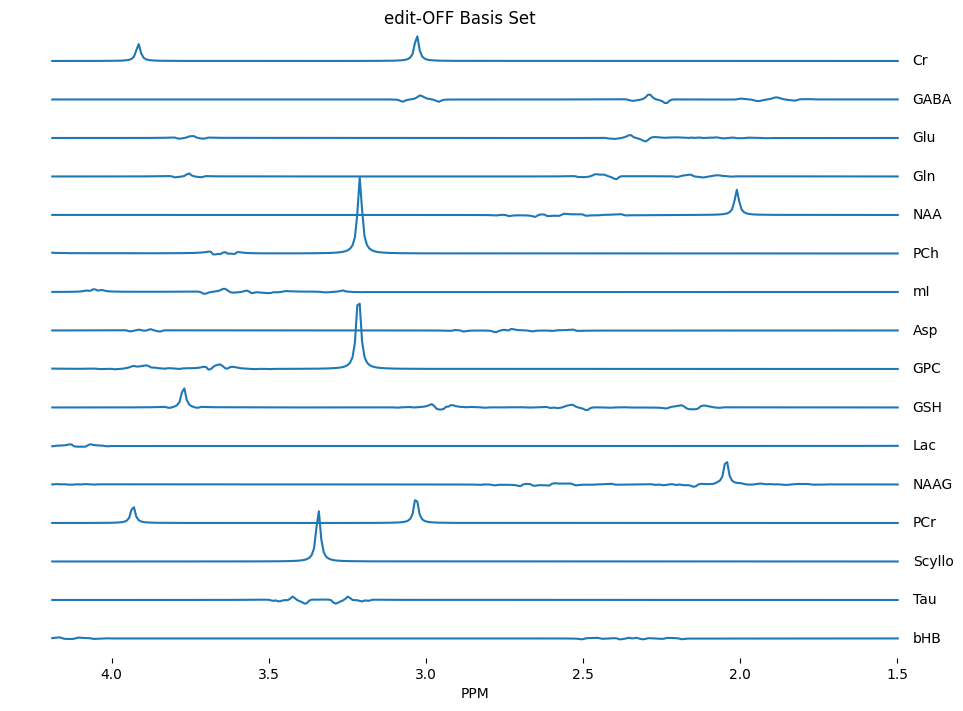

In [87]:
plot_basis(OFF_BASIS[ppm_15_idx:ppm_42_idx], METABOLITE_LIST_OFF, 1)

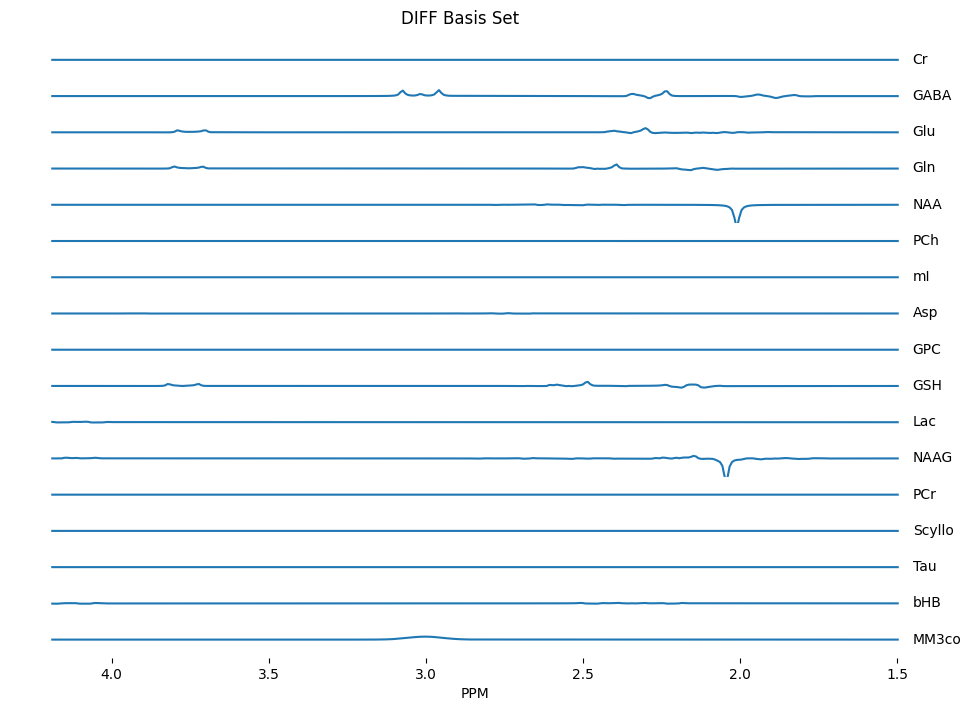

In [88]:
plot_basis(DIFF_BASIS[ppm_15_idx:ppm_42_idx], METABOLITE_LIST_DIFF, 3)

### Generate Simulated Spectra

In [ ]:
pip install sobol-seq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sobol_seq

In [ ]:
concentrations_sobol = sobol_seq.i4_sobol_generate(17, 20000) # num metab (including MM), num samples

In [ ]:
concentrations_sobol.shape

(20000, 17)

In [ ]:
OFF_SPEC_LIST = np.empty((20000, 2048), dtype=complex) # num samples, data points
for i, conc_list in enumerate( concentrations_sobol ):
    OFF_SPEC = np.zeros(2048, dtype=complex)
    for concentration, basis_func in zip(conc_list, np.transpose(OFF_BASIS)):
        OFF_SPEC += concentration*basis_func

    OFF_SPEC_LIST[i]=OFF_SPEC

In [ ]:
concentrations_sobol[0] = ([0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


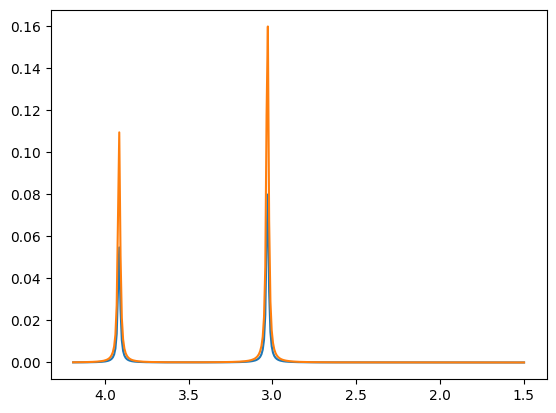

In [ ]:
plt.plot(PPM[ppm_15_idx:ppm_42_idx], OFF_SPEC_LIST[0, ppm_15_idx:ppm_42_idx])
plt.plot(PPM[ppm_15_idx:ppm_42_idx], OFF_BASIS[ppm_15_idx:ppm_42_idx,0])
plt.gca().invert_xaxis()

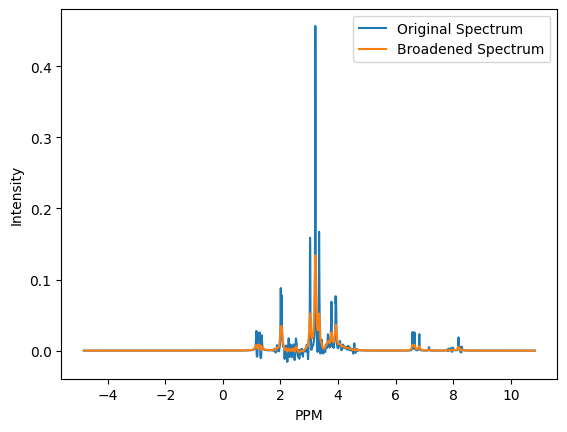

In [ ]:
def simulate_line_broadening(spectrum, linewidth):
    '''
    takes in a spectrum and a linewidth broadening factor
    '''
    n_points = len(spectrum)

    frequency_axis = np.fft.fftfreq(n_points)

    # Generate lineshape function (Lorentzian)
    lineshape = np.exp(-np.pi * linewidth * np.abs(frequency_axis))  # Assuming Lorentzian lineshape

    # Apply lineshape function to the spectrum in the frequency domain
    broadened_spectrum = np.fft.ifft(np.fft.fft(spectrum) * lineshape)

    return broadened_spectrum

# Define broadening factor
broadening_factor = 6

# Simulate line broadening
broadened_spectrum = simulate_line_broadening(OFF_SPEC_LIST[0], broadening_factor)

# Plot the original and broadened spectra
plt.plot(PPM, OFF_SPEC_LIST[0].real, label='Original Spectrum')
plt.plot(PPM, broadened_spectrum.real, label='Broadened Spectrum')
plt.xlabel('PPM')
plt.ylabel('Intensity')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


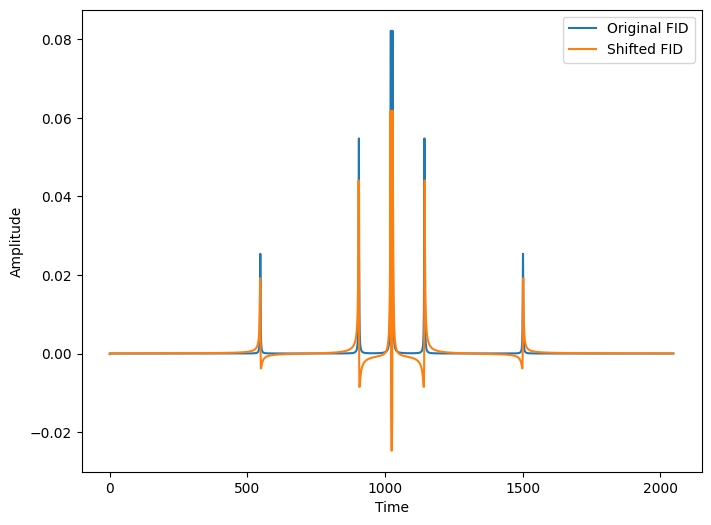

In [ ]:
# Simulated Free Induction Decay (FID) signal
fid_signal = OFF_BASIS_FID[:,0]

# Zero-order phase shift angle (in radians)
phase_shift = np.pi / 4

# Apply zero-order phase shift
fid_signal_shifted = fid_signal * np.exp(1j * phase_shift)

# Plotting the original and shifted FID signals

plt.figure(figsize=(8, 6))
plt.plot(spec_fft(np.real(fid_signal)), label='Original FID')
plt.plot(spec_fft(np.real(fid_signal_shifted)), label='Shifted FID')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Load In Vivo Spectra

In [89]:
DIFF_DATA = np.load('./registered_data/spectra_ON_OFF_Match_reg_Diff_NoOffset.npy') # David's spectra
OFF_DATA = np.load('./registered_data/spectra_ON_OFF_Match_reg_On_NoOffset.npy')

DIFF has axes swaped, and OFF is actually ON

In [90]:
DIFF_DATA = np.swapaxes(DIFF_DATA,0,1)
DIFF_DATA = np.swapaxes(DIFF_DATA,1,2)
DIFF_DATA.shape

(101, 160, 2048)

In [34]:
OFF_DATA.shape

(101, 160, 2048)

Average the 160 transients for OFF and DIFF and take real component:

In [91]:
OFF_avg = np.real( np.mean(OFF_DATA, axis=1) )
DIFF_avg = np.real( np.mean(DIFF_DATA, axis=1) )

Crop the spectra using the fitting range:

In [92]:
OFF_avg = OFF_avg[:, ppm_42_idx_vivo+2:ppm_15_idx_vivo+2]
DIFF_avg = -DIFF_avg[:, ppm_42_idx_vivo+2:ppm_15_idx_vivo+2]

Normalize

In [94]:
OFF_avg_norm = []
for spec in OFF_avg:
  OFF_avg_norm.append( np.flip(spec/np.max(np.abs(spec))) )
OFF_avg_norm = np.array(OFF_avg_norm)

DIFF_avg_norm = []
for spec in DIFF_avg:
  DIFF_avg_norm.append( np.flip(spec/np.max(np.abs(spec))) )
DIFF_avg_norm = np.array(DIFF_avg_norm)

In [96]:
# combine OFF and DIFF data
X_train_vivo = np.dstack(( OFF_avg_norm, DIFF_avg_norm ))

In [97]:
X_train_vivo.shape

(101, 353, 2)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


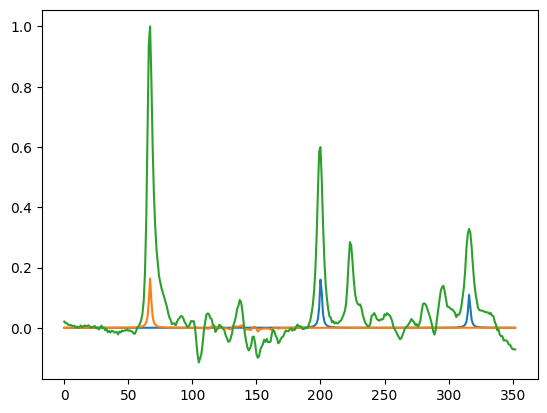

In [98]:
plt.plot( OFF_BASIS[ppm_15_idx:ppm_42_idx, 0] )
plt.plot( OFF_BASIS[ppm_15_idx:ppm_42_idx, 4] )
plt.plot( X_train_vivo[50, :, 0] )

### Define Model Architecture

In [99]:
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.layers import *
from keras.models import Model
from keras.layers import Conv2D
from tensorflow.python.keras.models import Sequential

In [27]:
input_shape = X_train_vivo[0].shape

Line broadening and the following fft have been performed using nitime and Numpy functions. Gradients cannot flow through Numpy functions, and converting Tensorflow tensors into Numpy arrays would mean transfer the data from GPU to be processed on the CPU. (https://github.com/tensorflow/tensorflow/blob/c256c071bb26e1e13b4666d1b3e229e110bc914a/tensorflow/python/framework/ops.py#L1126-L1138) line 1136

Must use tf operations.

In [122]:
#@title
######## GOOD MODEL - UNSupervised
input = Input(shape=input_shape) # OFF + DIFF = two channels
conv1 = Conv1D(32, kernel_size=3, activation='selu')(input)
pool1 = MaxPool1D(pool_size=2, strides=2, padding='valid')(conv1)

conv2 = Conv1D(64, kernel_size=3, activation='selu')(pool1)
pool2 = MaxPool1D(pool_size=2, strides=2, padding='valid')(conv2)

conv3 = Conv1D(128, kernel_size=3, activation='selu')(pool2)
pool3 = MaxPool1D(pool_size=2, strides=2, padding='valid')(conv3)

conv4 = Conv1D(256, kernel_size=3, activation='selu')(pool3)
pool4 = MaxPool1D(pool_size=2, strides=2, padding='valid')(conv4)

conv5 = Conv1D(512, kernel_size=3, activation='selu')(pool4)
pool5 = MaxPool1D(pool_size=2, strides=2, padding='valid')(conv5)

flat = Flatten()(pool5)
# dense1 = Dense(256, activation='selu')(flat)
dense2 = Dense(128, activation='selu')(flat)
dense3 = Dense(64, activation='selu')(dense2)
# dense4 = Dense(32, activation='selu')(dense3)
output = Dense(19, activation='linear', name='interm')(dense3) # predicts conc for 16 metab + conc for MM3c0 + linewidth + phase = 19 estimated values

indices_conc_off = tf.constant([ [0,0], [0,1], [0,2], [0,3], [0,4], [0,5], [0,6], [0,7], [0,8], [0,9], [0,10], [0,11], [0,12], [0,13], [0,14], [0,15] ]) # metab conc
indices_conc_diff = tf.constant([ [0,0], [0,1], [0,2], [0,3], [0,4], [0,5], [0,6], [0,7], [0,8], [0,9], [0,10], [0,11], [0,12], [0,13], [0,14], [0,15], [0,16] ]) # metab + MM3co conc
index_lw = tf.constant([ [0,17] ])
index_ph = tf.constant([ [0,18] ])

# Need to preserve None dimension corresponding to batch size
# since data (i.e. output_conc) has shape [None, 17], indices must have 2D shape (cannot be 1D), so that output has 2-1 = 1D shape
# this would remove the None dimension
# instead, add an extra dimension to data, and put batch dim to last - [17, X, None]
output_exp = tf.expand_dims (tf.transpose(output, perm=[1, 0]), axis=0)

# First taking the slice of the data, the third None dimension gets preserved - [17, None]
# transpose to get the original shape back - [None, 17]
output_conc_off = tf.transpose ( tf.gather_nd(output_exp, indices_conc_off) )
output_conc_diff = tf.transpose ( tf.gather_nd(output_exp, indices_conc_diff) )
# same thing with linewidth and phase
output_lw = tf.transpose ( tf.gather_nd(output_exp, index_lw) )
output_ph = tf.transpose ( tf.gather_nd(output_exp, index_ph) )

# # Scale all concentrations by concentration of Cr+PCr
# index_cr = tf.constant([ [0,0] ])
# index_pcr = tf.constant([ [0,12] ])
# output_cr = tf.transpose ( tf.gather_nd(output_exp, index_cr) )
# output_pcr = tf.transpose ( tf.gather_nd(output_exp, index_pcr) )
# output_crpcr = tf.add(output_cr, output_pcr)

# output_conc_off = tf.divide(output_conc_off, output_crpcr)
# output_conc_diff = tf.divide(output_conc_diff, output_crpcr)

# cast from float to complex
output_conc_off = tf.cast(output_conc_off, dtype=tf.complex128)
output_conc_diff = tf.cast(output_conc_diff, dtype=tf.complex128)

# Linear combination of basis set FIDS
output_off = tf.linalg.matmul(output_conc_off, OFF_BASIS_FID, transpose_b=True, output_type=tf.complex128) # have to convert to complex
output_diff = tf.linalg.matmul(output_conc_diff, DIFF_BASIS_FID, transpose_b=True, output_type=tf.complex128)

# Line broadening
time = tf.range(0.0, 1.0240, 5.0000e-04, dtype=tf.float32)

win = tf.math.exp( output_lw * tf.constant(35, dtype=tf.float32) * time )
#win = tf.math.exp( output_lw * tf.constant(5, dtype=tf.float32) * time )
win = tf.cast(win, tf.complex128)

fid_off_lb = tf.multiply(output_off, win) # both has to be dtype = [complex128] or complex64 for fft
fid_diff_lb = tf.multiply(output_diff, win)

# Phase shifting (zero-order only)
ph = tf.math.exp(tf.complex(0., -1.) * tf.complex(0., output_ph) * tf.complex(0., 45.) * tf.complex(0., math.pi) / tf.complex(0., 180.))
ph = tf.cast(ph, tf.complex128)

fid_off_ph = tf.multiply(fid_off_lb, ph)
fid_diff_ph = tf.multiply(fid_diff_lb, ph)

# FFT + shifting + take real component
spec_off = tf.math.real( tf.signal.fftshift(tf.signal.fft(fid_off_ph)) )
spec_diff = tf.math.real( tf.signal.fftshift(tf.signal.fft(fid_diff_ph)) )

# Cropping
zeros = tf.zeros([353], dtype=tf.int32)
    # ppm_range = tf.range(867, 1220, 1) # ppm_42_idx, ppm_15_idx, delta
ppm_range = tf.range(827, 1180, 1) # ppm_15_idx, ppm_42_idx, delta
ppm_range = tf.concat([tf.expand_dims(zeros, -1), tf.expand_dims(ppm_range, -1)], -1)

spec_off_exp = tf.expand_dims (tf.transpose(spec_off, perm=[1, 0]), axis=0)
spec_off_cropped = tf.transpose ( tf.gather_nd(spec_off_exp, ppm_range) )
spec_diff_exp = tf.expand_dims (tf.transpose(spec_diff, perm=[1, 0]), axis=0)
spec_diff_cropped = tf.transpose ( tf.gather_nd(spec_diff_exp, ppm_range) )

max_off = tf.expand_dims(tf.reduce_max(tf.math.abs(spec_off_cropped), axis=1), axis=-1)
max_diff = tf.expand_dims(tf.reduce_max(tf.math.abs(spec_diff_cropped), axis=1), axis=-1)

# Scaling
spec_off_cropped  = spec_off_cropped / tf.expand_dims(tf.reduce_max(tf.math.abs(spec_off_cropped), axis=1), axis=-1)
spec_diff_cropped  = spec_diff_cropped / tf.expand_dims(tf.reduce_max(tf.math.abs(spec_diff_cropped), axis=1), axis=-1)

# Concatenating OFF & DIFF
output_final = tf.concat([tf.expand_dims(spec_off_cropped, -1), tf.expand_dims(spec_diff_cropped, -1)], -1)

model_unsuper = Model(inputs=input, outputs=output_final)

In [ ]:
model_unsuper.summary()

In [123]:
max_off.shape

TensorShape([None, 1])

### Train Model

In [ ]:
# @title

# optimiser = keras.optimizers.Adam(learning_rate=1e-4,
#                                   beta_1=0.9,
#                                   beta_2=0.999,
#                                   amsgrad=True)

# def custom_loss(spec_true, spec_pred):
#     loss_off_real = K.abs(tf.math.real(spec_pred[:,:,0]) - tf.math.real(spec_true[:,:,0]))
#     loss_off_real = K.mean(loss_off_real, axis=-1)
#     loss_off_imag = K.abs(tf.math.imag(spec_pred[:,:,0]) - tf.math.imag(spec_true[:,:,0]))
#     loss_off_imag = K.mean(loss_off_imag, axis=-1)

#     loss_diff_real = K.abs(tf.math.real(spec_pred[:,:,1]) - tf.math.real(spec_true[:,:,1]))
#     loss_diff_real = K.mean(loss_diff_real, axis=-1)
#     loss_diff_imag = K.abs(tf.math.imag(spec_pred[:,:,1]) - tf.math.imag(spec_true[:,:,1]))
#     loss_diff_imag = K.mean(loss_diff_imag, axis=-1)
#     return loss_off_real + loss_off_imag + loss_diff_real + loss_diff_imag

# model_unsuper.compile(loss=custom_loss,
#               optimizer=optimiser,
#               metrics=['mse'])

In [101]:
optimiser = keras.optimizers.Adam(learning_rate=1e-4,
                                  beta_1=0.9,
                                  beta_2=0.999,
                                  amsgrad=True)

def custom_loss(spec_true, spec_pred):
    loss_off = K.abs(spec_pred[:,:,0] - spec_true[:,:,0])
    loss_off = K.mean(loss_off, axis=-1)

    loss_diff = K.abs(spec_pred[:,:,1] - spec_true[:,:,1])
    loss_diff = K.mean(loss_diff, axis=-1)
    return loss_off + loss_diff

model_unsuper.compile(loss='mae',
              optimizer=optimiser,
              metrics=['mse'])

In [102]:
epochs=3000
batch_size=10

callbacks = [keras.callbacks.EarlyStopping(monitor='loss',
                                           min_delta=1e-12,
                                           patience=50,
                                           verbose=1,
                                           restore_best_weights=True)]

history = model_unsuper.fit(x=X_train_vivo,
                    y=X_train_vivo,
                    batch_size=batch_size,
                    epochs=epochs,
                    #validation_data=(X_val_vivo, X_val_vivo),
                    verbose=1,
                    shuffle=False,
                    callbacks=callbacks)

Epoch 1/3000


11/11 [==============================] - 3s 11ms/step - loss: 0.0901 - mse: 0.0265
Epoch 2/3000
11/11 [==============================] - 0s 10ms/step - loss: 0.0513 - mse: 0.0092
Epoch 3/3000
11/11 [==============================] - 0s 10ms/step - loss: 0.0406 - mse: 0.0048
Epoch 4/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.0355 - mse: 0.0035
Epoch 5/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.0357 - mse: 0.0036
Epoch 6/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.0340 - mse: 0.0034
Epoch 7/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.0325 - mse: 0.0032
Epoch 8/3000
11/11 [==============================] - 0s 10ms/step - loss: 0.0320 - mse: 0.0031
Epoch 9/3000
11/11 [==============================] - 0s 9ms/step - loss: 0.0317 - mse: 0.0031
Epoch 10/3000
11/11 [==============================] - 0s 10ms/step - loss: 0.0312 - mse: 0.0030
Epoch 11/3000
11/11 [==============================] - 0s

In [141]:
model_unsuper.save_weights('./models/model_unsuper_weights.h5')

np.save('./models/model_unsuper_history.npy', history.history)

# model_unsuper.save('./Registered_data/model_unsuper.h5') # lighter h5 version Keras also supports saving a single HDF5 file containing
# # the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel.

In [166]:
history= np.load('./models/model_unsuper_history.npy',allow_pickle='TRUE').item()

model_unsuper.load_weights('./models/model_unsuper_weights.h5')

### Make Predictions

In [103]:
prediction = model_unsuper.predict(X_train_vivo)

4/4 [==============================] - 0s 7ms/step


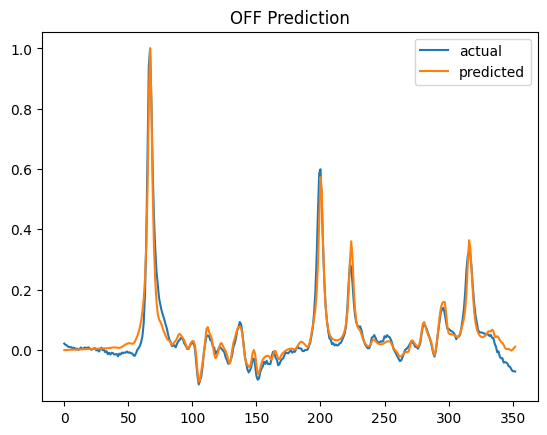

In [104]:
plt.plot(X_train_vivo[50, :, 0], label='actual')
# plt.plot(OFF_BASIS[ppm_15_idx:ppm_42_idx,0], label='basis')
plt.plot(prediction[50, :, 0], label='predicted')
plt.title('OFF Prediction')
plt.legend()

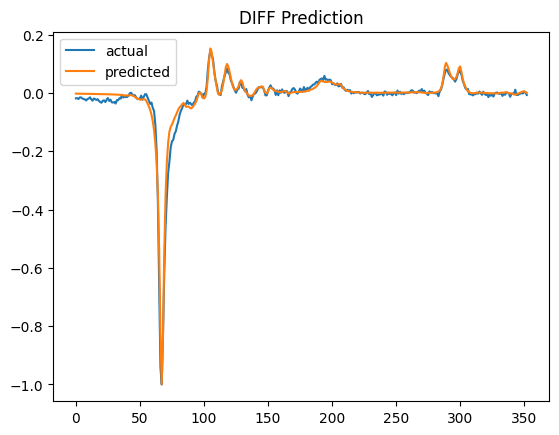

In [105]:
plt.plot(X_train_vivo[50, :, 1], label='actual')
# plt.plot(OFF_BASIS[ppm_15_idx:ppm_42_idx,0], label='basis')
plt.plot(prediction[50, :, 1], label='predicted')
plt.title('DIFF Prediction')
plt.legend()

In [116]:
# get model prediction for concentration values, linebroadening factor, and phase
layer_name = 'interm'
intermediate_layer_model = Model(inputs=model_unsuper.input,
                                 outputs=model_unsuper.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train_vivo)

4/4 [==============================] - 0s 3ms/step


In [ ]:
# get model prediction for concentration values, linebroadening factor, and phase
layer_name = 'interm'
intermediate_layer_model = Model(inputs=model_unsuper.input,
                                 outputs=model_unsuper.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train_vivo)

In [107]:
def plot_compare_multiple(spec_list_true, spec_list_pred, conc_list_pred, num_samples):
    """
    list of target spectra, list of predicted spectra, list of predicted concentrations, number of samples to plot
    """

    spec_list_true = spec_list_true[41:41+num_samples]
    spec_list_pred = spec_list_pred[41:41+num_samples]

    fig, axes = plt.subplots(num_samples, 3, figsize=(12,8), constrained_layout=True)


    # METABOLITE_LIST = ['Creatine', 'GABA', 'Glutamate', 'Glutamine', 'N-Acetylaspartate']
    METABOLITE_LIST = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB']
    x = np.arange(len(METABOLITE_LIST))

    i = 0
    for spec_true, spec_pred, conc_pred in zip(spec_list_true, spec_list_pred, conc_list_pred):

        axes[i][0].plot(PPM[ppm_15_idx:ppm_42_idx], spec_true[:, 0], label='actual')
        axes[i][0].plot(PPM[ppm_15_idx:ppm_42_idx], spec_pred[:, 0], label='predicted', linestyle='dashed')
        axes[i][0].set_xlabel('PPM')
        axes[i][0].invert_xaxis()

        axes[i][1].plot(PPM[ppm_15_idx:ppm_42_idx], spec_true[:, 1], label='actual')
        axes[i][1].plot(PPM[ppm_15_idx:ppm_42_idx], spec_pred[:, 1], label='predicted', linestyle='dashed')
        axes[i][1].set_xlabel('PPM')
        axes[i][1].invert_xaxis()

        axes[i][2].bar(x, conc_pred[:16], 0.75)
        axes[i][2].set_ylabel('Concentrations')
        # axes[i][2].set_ylim([0,1.5])
        axes[i][2].set_xticks(x)
        axes[i][2].set_xticklabels(METABOLITE_LIST, rotation='vertical')
        # axes[i][2].text(0, 0, 'MAPE: ' + str(mean_absolute_percentage_error(conc_true, conc_pred)) + '%')


        title_0 = ' Spec type: OFF '
        title_1 = ' Spec type: DIFF '
        title_2 = ' Estimated concentrations'

        axes[0][0].legend()
        axes[0][1].legend()
        # axes[0][2].legend(loc='upper center')
        axes[0][0].set_title(title_0)
        axes[0][1].set_title(title_1)
        axes[0][2].set_title(title_2)

        i = i + 1

    fig.suptitle('CNN Prediction Results on In Vivo Data')
    # fig.tight_layout(pad=0., w_pad=0.3, h_pad=1.0)

    plt.show()
    # fig.savefig('CNN Prediction Results.png')

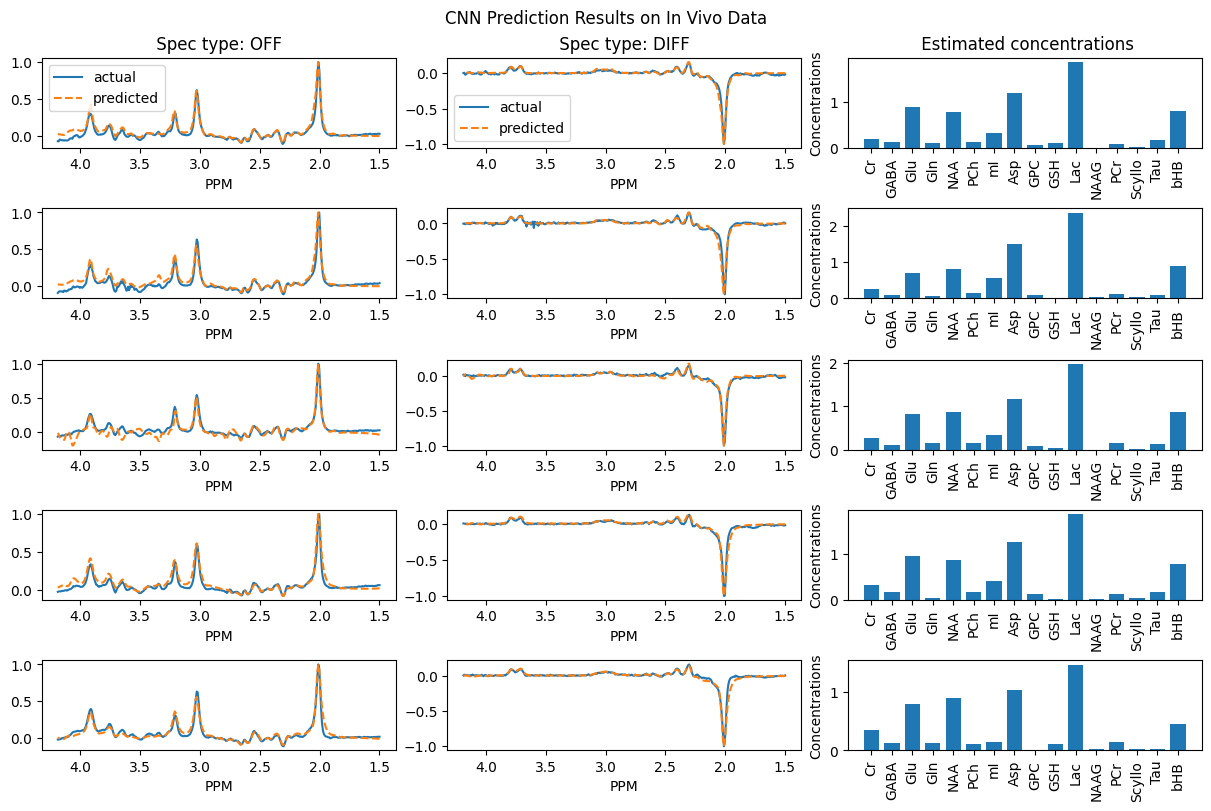

In [108]:
plot_compare_multiple(X_train_vivo, prediction, np.abs(intermediate_output), 5)

In [150]:
METABOLITE_LIST_OFF = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB']
METABOLITE_LIST_DIFF = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB', 'MM3co']

In [55]:
METABOLITE_LIST_OFF = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh']

In [47]:
# def plot_basis(spec_list, METAB_LIST, edit, conc_list_pred):
#     """
#     takes in list of basis spectra, list of metabolite names, edit (1=OFF, 2=ON, 3=DIFF). The individual basis spectra are normalized by their max values
#     """

#     spec_list = np.real(spec_list)

#     fig = plt.figure(figsize=(10,5))

#     y_spacing = 0 # use to space out the spectra vertically

#     # iterate through spectra and axes
#     for (spec, metab, conc) in zip(reversed(np.transpose(spec_list)), reversed(METAB_LIST), reversed(conc_list_pred)):

#         plt.plot(PPM[ppm_15_idx:ppm_42_idx], spec/np.max(np.abs(spec))*conc+y_spacing, label=metab, clip_on=False)
#         plt.annotate(metab, xy=(1.45,-0.2+y_spacing+0.19)) # show metabolite name on the right side of the spectrum

#         # Remove the y-axis spines
#         plt.gca().spines['left'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)
#         plt.gca().spines['top'].set_visible(False)
#         plt.gca().spines['bottom'].set_visible(False)

#         # Remove ticks and labels on the y-axis
#         plt.yticks([])

#         # Set the y-limits to center the plots vertically
#         plt.ylim((-0.2, 1.1))

#         y_spacing += 0.2

#     plt.gca().invert_xaxis()
#     plt.xlabel('PPM')

#     # remove vertical gap between subplots
#     plt.subplots_adjust(hspace=.0)

#     # set title
#     # if edit == 1:
#     #     fig.suptitle('edit-OFF Basis Set', y=0.7)
#     # elif edit == 2:
#     #     fig.suptitle('edit-ON Basis Set', y=0.7)
#     # else:
#     #     fig.suptitle('DIFF Basis Set', y=0.7)

#     plt.show()
#     # fig.savefig('CNN Prediction Results.png')

In [ ]:
#plot_basis(OFF_BASIS[ppm_15_idx:ppm_42_idx, :6], METABOLITE_LIST_OFF, 1, np.abs(intermediate_output[41,:6]))

In [126]:
def plot_residual(spec_list_true, spec_list_pred, conc_list_pred, num_samples):
    """
    list of target spectra, list of predicted spectra, list of predicted concentrations, number of samples to plot
    """

    spec_list_true = spec_list_true[41:41+num_samples]
    spec_list_pred = spec_list_pred[41:41+num_samples]

    fig, axes = plt.subplots(2, 2, figsize=(12,8))

    METABOLITE_LIST = ['Cr', 'GABA', 'Glu', 'Gln', 'NAA', 'PCh', 'mI', 'Asp', 'GPC', 'GSH', 'Lac', 'NAAG', 'PCr', 'Scyllo', 'Tau', 'bHB']
    x = np.arange(len(METABOLITE_LIST))

    i = 0
    for spec_true, spec_pred, conc_pred in zip(spec_list_true, spec_list_pred, conc_list_pred):

        axes[0][i].hlines(y=0, xmin=PPM[ppm_15_idx], xmax=PPM[ppm_42_idx], linestyle='dashed', color ='r')
        axes[0][i].plot(PPM[ppm_15_idx:ppm_42_idx], spec_true[:, 0] - spec_pred[:, 0], label='residual')
        axes[0][i].set_ylim([-0.2, 1.1])
        axes[0][i].xaxis.set_ticks([])
        axes[0][i].xaxis.set_ticklabels([])
        axes[0][i].spines['bottom'].set_visible(False)
        axes[0][i].invert_xaxis()

        axes[1][i].hlines(y=0, xmin=PPM[ppm_15_idx], xmax=PPM[ppm_42_idx], linestyle='dashed', color ='r')
        axes[1][i].plot(PPM[ppm_15_idx:ppm_42_idx], spec_true[:, 0], label='actual')
        axes[1][i].plot(PPM[ppm_15_idx:ppm_42_idx], spec_pred[:, 0], label='predicted', linestyle='dashed')
        axes[1][i].set_ylim([-0.2, 1.1])
        axes[1][i].set_xlabel('PPM')
        axes[1][i].invert_xaxis()

        title_0 = ' Spec type: OFF '
        title_1 = ' Residual '

        axes[0][0].legend(loc='upper left')
        axes[1][0].legend()
        # axes[0][0].set_title(title_0)
        # axes[1][0].set_title(title_1)

        i = i + 1

    fig.subplots_adjust(wspace=0.1, hspace=0)

    fig.suptitle('CNN Prediction Results (Residuals) on In Vivo Data')
    # fig.tight_layout(pad=0., w_pad=0.3, h_pad=1.0)

    plt.show()
    # fig.savefig('CNN Prediction Results.png')

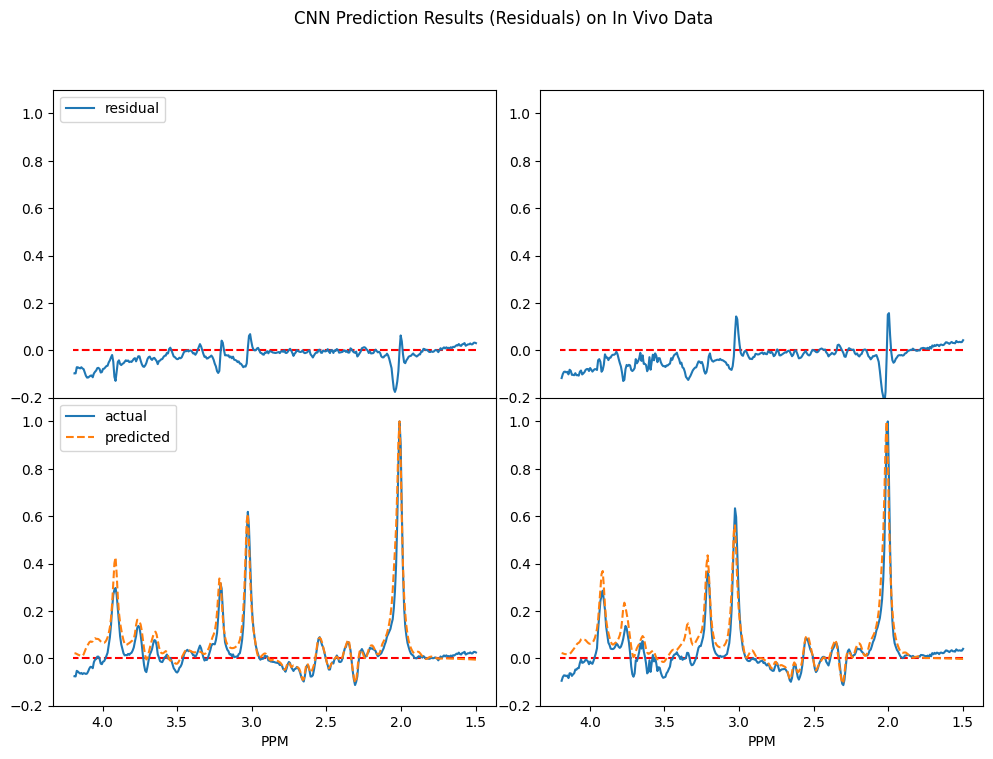

In [127]:
plot_residual(X_train_vivo, prediction, np.abs(intermediate_output), 2)